# Week 3

## Functions from previous weeks

Find all (k, d)-motifs in a collection of strings

In [6]:
def FrequentWordsWithMismatches(
    Text, k, d, print_output=False
):
    Patterns = list()
    freqMap = dict()
    n = len(Text)

    for i in range(0, n-k+1):
        Pattern = Text[i:i+k] # перебираем паттерны по строке
        neighborhood = Neighbors(Pattern, d) # создаем множество соседей - паттернов, которые отличаются от нашего паттерна на d

        for j in range(len(neighborhood) - 1): # проверяем всех соседей по словарю, добавляем +1 счет
            neighbor = neighborhood[j]

            if neighbor not in freqMap:
                freqMap[neighbor] = 1
            else:
                freqMap[neighbor] += 1

    maxPattern = MaxFreq(freqMap) # находим максимумальное значение по строке в словаре и выводим все паттерны, у которых столько совпадений со строкой
    for key in freqMap:
        if freqMap[key] == maxPattern:
            Patterns.append(key)

    if print_output:
        print(*Patterns)
    else:
        return Patterns


def HammingDistance(p, q):
    hammingDist = 0

    for i in range(len(p)):
        if p[i] != q[i]:
            hammingDist += 1

    return hammingDist


def Neighbors(Pattern, d):
    if d == 0:
        return Pattern
    if len(Pattern) == 1:
        return {'A', 'T', 'G', 'C'}
    
    Neighborhood = set()
    NeighborSuffix = Neighbors(Suffix(Pattern), d)

    for Neighbor in NeighborSuffix:
        if HammingDistance(Suffix(Pattern), Neighbor) < d:
            for i in 'ATGC':
                Neighborhood.add(i+Neighbor)
        else:
            Neighborhood.add(Pattern[0] + Neighbor)
            
    return list(Neighborhood)


def MaxFreq(Dictionary: dict):
    '''
    Function to return max value from dictionary
    '''

    maxValue = max(
        Dictionary, key=Dictionary.get
    )
    return Dictionary[maxValue]


def SortPatternsDict(Dictionary):
    '''
    Function return dictionary sorted by value.
    '''

    sortedDict = {
        key: value for key, value in sorted(Dictionary.items(), key=lambda item: item[1], reverse=True)
    }
    return sortedDict
    
    
def Suffix(Pattern):
    return Pattern[1:]

## BruteForceMotifSearch

A brute force approach for solving the Implanted Motif Problem is based on the observation that any (k, d)-motif must be at most d mismatches apart from some k-mer appearing in the first string in Dna. Therefore, we can generate all such k-mers and then check which of them are (k, d)-motifs.

In [7]:
def MotifEnumerator(
    k, d, 
):
    # Dna = [sequence for sequence in input("Enter sequences, separated by space:").split()]
    DnaList = [
        'GTTTCACGTCAGTACCCGCAGGAGA', 'GGATCTCCGCTAGTTTCCGTAGTAC', 'GGTTACACAATGTACCACACGTCCG', 
        'GCGCCCTAGAGACACCCCAGCGTAC', 'TGGGGCGTACTGGCACGGTGAAAGA', 'CCGGCAGTACGGTTATACAGTCGCA'
    ]

    # Делаем список со списками k-меров для каждого кусочка последовательности
    PatternList = [ 
        [Dna[i:i+k] for i in range(len(Dna)-k+1)]
        for Dna in DnaList 
    ]

    # Делаем список с множествами, куда запишем всех соседей Neighbors для всех k-меров для каждого кусочка последовательности 
    set_list = list()
    for i in PatternList:
        total_list = list()
        for j in i:
            total_list += Neighbors(j, d)
        set_list.append(set(total_list))
    
    # Делаем итоговый список, который постепенно уменьшается засчет пересечения с каждым следующим множеством, 
    # оставляя только такие k-меры, которые есть во всех входных последовательностях
    patterns = set_list[0]
    for k_set in set_list:
        patterns = patterns & k_set

    return list(patterns)

In [8]:
x = MotifEnumerator(5, 1)
print(*x)

TGTAC CGTAC GGTAC AGTAC


This is fucked as fuck. Let's check, what will happen next..

But our motifs may differ greatly, so we won't be able to track them so easily

Moreover, there are regions in motifs which are highly conservative, and there are motifs, which are highly variable.
For example, the sixteen nucleotide-long CSRE transcription factor binding site in the yeast species S. cerevisiae consists of five strongly conserved positions (1, 8, 9, 12, and 13) in addition to eleven weakly conserved positions, each of which features two nucleotides with similar frequencies

## CountEntropy

We can use Enthropy to estimate the motif. The entropy of a motif matrix is defined as the sum of the entropies of its columns.

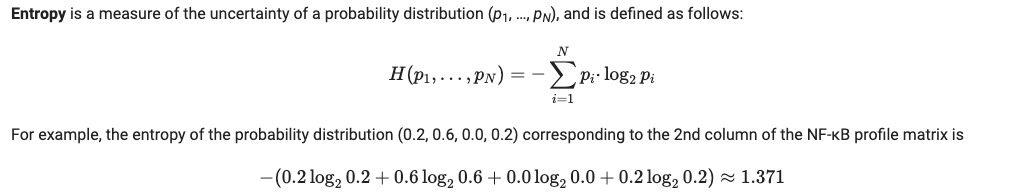

In [33]:
import math

In [34]:
def CountEnthropy(Nucleotides):
    summEntropy = 0
    for base in 'ATGC':
        probBase = Nucleotides.count(base)/len(Nucleotides)
        if probBase != 0:
            summEntropy += probBase * math.log2(probBase)
    return -summEntropy

    
Motifs = [
    "TCGGGGGTTTTT",
    "CCGGTGACTTAC",
    "ACGGGGATTTTC",
    "TTGGGGACTTTT",
    "AAGGGGACTTCC",
    "TTGGGGACTTCC",
    "TCGGGGATTCAT",
    "TCGGGGATTCCT",
    "TAGGGGAACTAC",
    "TCGGGTATAACC"
]

totalEnthtopyByCol = 0

for j in range(len(Motifs[0])): # перебором по элементам в строках составляем столбцы, считаем по ним энтропию и суммируем
    nucleotidesColumn = str()
    for motif in Motifs:
        nucleotidesColumn += motif[j]
    totalEnthtopyByCol += CountEnthropy(nucleotidesColumn)

print("Total Enthropy for the Matrix by Column:", round(totalEnthtopyByCol, 4))

Total Enthropy for the Matrix by Column: 9.9163


## MedianString

Because BruteForceMotifSearch is inefficient, we will think about motif finding in a different way. 

Instead of exploring all Motifs in Dna and deriving the consensus string from Motifs afterwards, we will explore all potential k-mer consensus strings first and then find the best possible collection Motifs for each consensus string

By understanding that Score can be calculated not only by columns, but also by rows, we can create following algorithm

In [35]:
from itertools import product

In [36]:
def MedianStringMotif(Dna, k):
    '''
    Function that checks distances for all possible k-mers against input list of sequences
    Returns Pattern, which has minimal total distance across input dataset
    '''
    kMerList = [''.join(base) for base in product('ATGC', repeat=k)] # делаем лист всех возможных комбинаций по k букв из набора ATGC
    distance = 1000000
    Median = str()

    for Pattern in kMerList: # каждый из k-меров проверяется функцией, насколько он совпадает с каждой строкой из инпута
        PatternDistance = DnaDistance(Pattern, Dna, k)
        if distance > PatternDistance: # если он близок, записываем его как Медиану, а его расстояние до датасета становится новым минимальным
            distance = PatternDistance
            Median = Pattern
    
    return Median


def DnaDistance(Pattern, Dna, k):
    '''
    Function to compare pattern with all strings in input, compute minimal distances and return summary of minimal distances
    '''
    return sum([
        min([
            HammingDistance(Pattern, dna[i:i+k]) for i in range(len(dna) - k + 1)
        ]) for dna in Dna
    ])
    # для каждой последовательности в датасете мы идем по ее длине и находим расстояния Хэмминга (отличия между последовательностями)


In [37]:
DnaDistance(
    'TTCGTT', [ i.strip() for i in input().split() ], 6
)

0

In [38]:
MedianStringMotif(
    Dna = [seq.strip() for seq in input().split()],
    k= 3
)

'AAA'